<a href="https://colab.research.google.com/github/5tu/5tu.github.io/blob/master/OpenCV_Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [149]:
!pip install ipython-autotime
%load_ext autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 384 µs (started: 2024-10-10 15:15:16 +00:00)


In [166]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

time: 3.63 s (started: 2024-10-10 15:55:24 +00:00)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


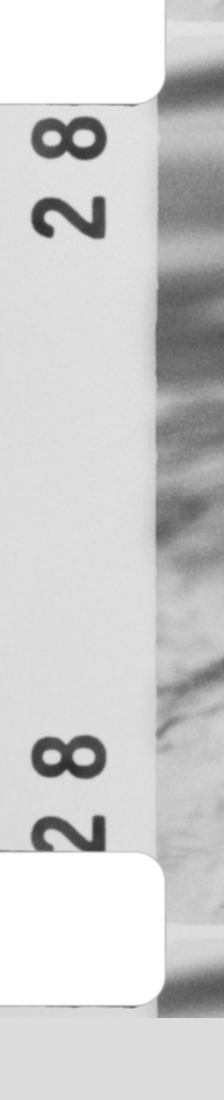

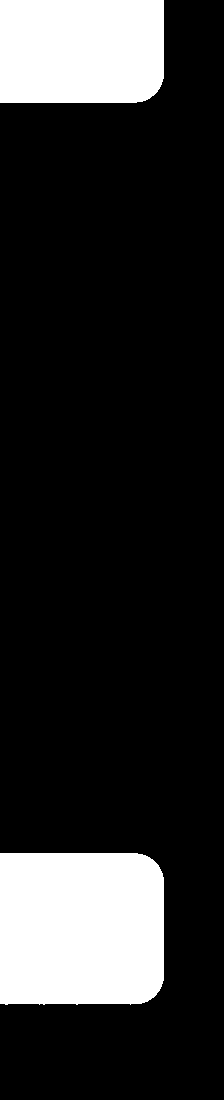

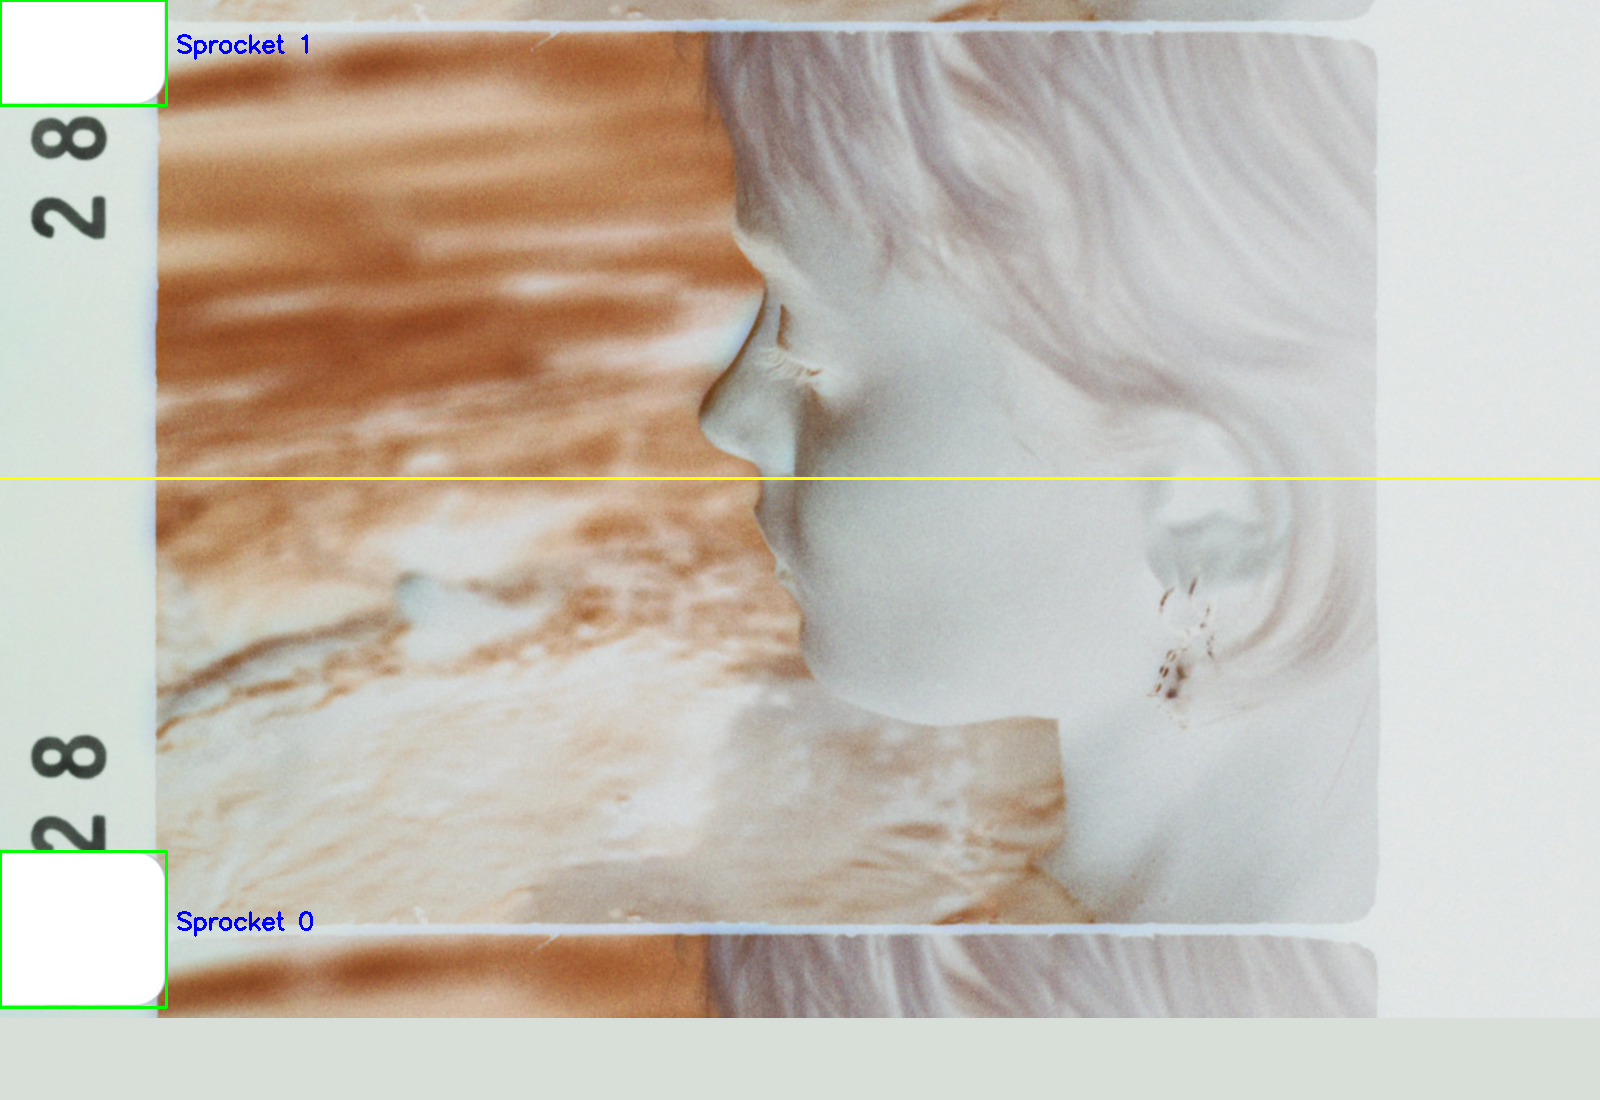

True

In [14]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')
images_dir = ('/content/drive/MyDrive/Film/OpenCVTest')

crop_amount = 0.14

# Load the image and convert it to grayscale
image_path = '/content/drive/MyDrive/Film/OpenCVTest/Sources/S16_crop_misaligned.png'
image = cv2.imread(image_path)

# Select the area of interest from the leftmost edge to 10% in
image_width = image.shape[1]
roi_end = int(image_width * crop_amount)

# Crop the image to the selected area of interest
image_roi = image[:, :roi_end]

# Convert the cropped image to grayscale
gray_image_roi = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)

# Find the brightest value in the image
brightest_value = np.max(gray_image_roi)
cv2_imshow(gray_image_roi)

# Create a binary image with a threshold 5% below the brightest value
threshold = brightest_value * 0.95
_, binary_image = cv2.threshold(gray_image_roi, threshold, 255, cv2.THRESH_BINARY)
cv2_imshow(binary_image)

# Apply the Sobel operator for edge detection on the binary image
sobelx = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=5)

# Compute the gradient magnitude
gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

# Normalize the gradient magnitude to the range [0, 255]
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Convert the gradient magnitude to uint8 for contour detection
gradient_magnitude = np.uint8(gradient_magnitude)

# Find contours in the gradient magnitude image
contours, _ = cv2.findContours(gradient_magnitude, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the image dimensions
height, width, _ = image.shape  # Define height here

# Check if any detected shape intersects with the top or bottom of the image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    if y == 0 or y + h == height:
        print("Warning: Detected shape edge is coincident with the top or bottom edge of the frame.")

# Iterate over the contours
shape_counter = 0
shape_centers = []

for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)  # Adjust the epsilon value for smoother approximation

    if len(approx) >= 4:
        # Perform further checks or draw the bounding box if the contour has 4 or more vertices
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Write the shape number next to the detected shape
        cv2.putText(image, f'Sprocket {shape_counter}', (x + w + 10, y + h // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        shape_counter += 1

        # Assuming the upper rectangle is at index 0 and the lower rectangle is at index 1 in the contours list

upper_rect = cv2.boundingRect(contours[1])
lower_rect = cv2.boundingRect(contours[0])

upper_bottom = upper_rect[1] + upper_rect[3]  # Calculate bottom edge of upper rectangle
lower_top = lower_rect[1]  # Calculate top edge of lower rectangle

midpoint = (upper_bottom + lower_top) // 2  # Calculate the midpoint

# Draw a horizontal orange line at the midpoint
cv2.line(image, (0, midpoint), (width, midpoint), (0, 255, 255), 2)

cv2_imshow(image)


# Save the original image with identified features overlay to the specified directory
cv2.imwrite(f"{images_dir}/Output/Untitled.jpg", image)